In [1]:
import agb.string.agbstring
import agb.image, agb.palette, agb.lz77
import struct
from pymap.project import Project
import json
from PIL import Image, ImageDraw
import numpy as np
from copy import deepcopy
import os
from collections import defaultdict
import pickle, pathlib
from tqdm import tqdm
import os.path as osp
import itertools

In [2]:
with open(os.path.join('.', 'bld', 'violet.gba'), 'rb') as f:
    rom = f.read()

In [10]:
image_offset = 0x0111B3C0
palette_offset = 0x018951EC

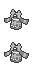

In [11]:

image = agb.image.Image(rom[image_offset : (image_offset + 32 * 32)], 32, 64)
    
palette = agb.palette.from_data(rom[palette_offset : palette_offset + 32])
image.to_pil_image(palette.to_pil_palette())

In [2]:
path = os.path.join('asset', 'gfx', 'pokemon_icons', 'gfx_pkmn_mega_jugong_icon.png')
img, palette = agb.image.from_file(path)
path_greyscale = os.path.join('asset', 'gfx', 'pokemon_icons_greyscale', 'gfx_pokemon_icon_grey.png')
_, palette_greyscale = agb.image.from_file(path_greyscale)
img.apply_palette(palette, palette_greyscale)

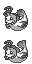

In [6]:
img.to_pil_image(palette_greyscale.to_pil_palette())

In [2]:
with open(os.path.join('.', 'bld', 'violet.gba'), 'rb') as f:
    rom = f.read()
project = Project('proj.pmp')

In [3]:
offset_icon_pals = 0x3D3054
hex(project.model['pointer'].from_data(rom, offset_icon_pals, project, [], []))

'0x3210426c'

In [9]:

pals = [agb.palette.from_data(rom[i * 16 * 2 + offset_icon_pals : (i + 1) * 16 * 2 + offset_icon_pals]) for i in range(3)]

In [28]:
colors = np.concatenate([pal.rgbs[1:] for pal in pals])
colors_grey = (colors * np.array([.299, .587, .114])).sum(-1)

colors_grey_discretized = colors_grey.astype(int) // 8 * 8

sorted(set(colors_grey_discretized))

[56,
 88,
 112,
 120,
 128,
 136,
 144,
 152,
 160,
 168,
 176,
 184,
 192,
 200,
 216,
 224,
 248]

In [26]:
greys = [56,
88,
 112,
 120,
 128,
 136,
 144,
 152,
 160,
 176,
 184,
 192,
 200,
 216,
 248]
assert len(greys) <= 15

In [ ]:
# Map from the original pals to the discretized grey in terms of 

In [2]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

In [47]:
np.asscalar = float

pal_idx_to_grey_pal_idx = [
    {0 : 0} for _ in pals
]

for pal_idx, pal in enumerate(pals):
    for color_idx in range(1, 16):
        rgb_src = sRGBColor(*(pal.rgbs[color_idx] / 256))
        lab_src = convert_color(rgb_src, LabColor)
        
        best_grey_idx, best_distance = None, np.inf
        
        for grey_idx, grey in enumerate(greys):
            grey_idx += 1
            rgb_target = sRGBColor(*(np.array([grey, grey, grey]) / 256))
            lab_target = convert_color(rgb_target, LabColor)
            distance = delta_e_cie2000(lab_src, lab_target)
            if distance < best_distance:
                best_grey_idx, best_distance = grey_idx, distance
        pal_idx_to_grey_pal_idx[pal_idx][color_idx] = best_grey_idx

In [48]:
pal_idx_to_grey_pal_idx

[{0: 0,
  1: 5,
  2: 11,
  3: 15,
  4: 9,
  5: 15,
  6: 5,
  7: 9,
  8: 6,
  9: 2,
  10: 8,
  11: 12,
  12: 12,
  13: 8,
  14: 2,
  15: 1},
 {0: 0,
  1: 3,
  2: 11,
  3: 15,
  4: 7,
  5: 11,
  6: 14,
  7: 8,
  8: 10,
  9: 9,
  10: 14,
  11: 15,
  12: 13,
  13: 5,
  14: 2,
  15: 1},
 {0: 0,
  1: 4,
  2: 11,
  3: 15,
  4: 4,
  5: 10,
  6: 6,
  7: 13,
  8: 10,
  9: 15,
  10: 7,
  11: 6,
  12: 10,
  13: 3,
  14: 2,
  15: 1}]

In [49]:
%pwd

'\\\\wsl$\\Ubuntu\\home\\dominik\\Violet\\Violet'

In [4]:
path = os.path.join('asset', 'gfx', 'pokemon_icons', 'gfx_pkmn_mega_jugong_icon.png')
img, palette = agb.image.from_file(path)
path_greyscale = os.path.join('asset', 'gfx', 'pokemon_icons_greyscale', 'gfx_pokemon_icon_grey.png')
_, palette_greyscale = agb.image.from_file(path_greyscale)
img.apply_palette(palette, palette_greyscale)

TypeError: object of type 'module' has no len()

In [65]:
palette_grey = agb.palette.Palette([[grey, grey, grey] for grey in greys])

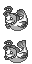

In [72]:
def map_image_to_greyscale_pal(path, greys):
    img, palette = agb.image.from_file(path)
    
    # remap palette
    palette_map = np.zeros(16, dtype=int)
    
    for color_idx in range(1, 16):
        best_distance = np.inf
        rgb_src = sRGBColor(*(palette.rgbs[color_idx] / 256))
        lab_src = convert_color(rgb_src, LabColor)
        for grey_idx, grey in enumerate(greys):
            rgb_target = sRGBColor(*(np.array([grey, grey, grey]) / 256))
            lab_target = convert_color(rgb_target, LabColor)
            distance = delta_e_cie2000(lab_src, lab_target)
            if distance < best_distance:
                best_distance = distance
                palette_map[color_idx] = grey + 1
    
    img.data = palette_map[img.data]
    return img
        
    
img = map_image_to_greyscale_pal(os.path.join('asset', 'gfx', 'pokemon_icons', 'gfx_pkmn_mega_jugong_icon.png'), greys)
img.to_pil_image(palette_grey.to_pil_palette())


In [71]:
img.save('default.png', palette_grey.to_pil_palette())